# Домашнее задание № 4

## Основное задание

Возьмите датасет https://www.kaggle.com/ajayrana/hymenoptera-data/kernels
1. Обучите на нем модели ResNet 18 и VGG 16 с нуля (5-10 эпох)
2. Обучите на нем модели ResNet 18 и VGG 16 с использованием FineTuning (5-10 эпох)
3. Добавьте аугментацию данных к пункту 2

Сравните качество всех 3 полученных подходов

## Задание со звездочкой
Примените FineTuning ResNet 18 к FashionMnist. Удалось ли увидеть резкое увеличение качества?



### Для начала загрузим dataset:

source: https://www.kaggle.com/ryches/pytorch-intro 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision as tv
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [102]:
data_dir = r"C:\Users\Nikita\Documents\Нетология_DataScience\Deep_Learning\Modern CNN\hymenoptera_data\hymenoptera_data"

In [26]:
BATCH_SIZE=32

normalize = tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transoforms = tv.transforms.Compose([
    tv.transforms.Resize((224,224)),
    tv.transforms.ToTensor(),
    normalize
])

train_dataset = tv.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transoforms)
test_dataset = tv.datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transoforms)

train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,  shuffle=True)

class_names = train_dataset.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. ResNet 18 & VGG 16 с нуля:

### Модель ResNet 18:

In [8]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = torch.Tensor([0]), 0
    net.eval()
    for X, y in data_iter:
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [100]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
            print("Step. time since epoch: {:.3f}. Train acc: {:.3f}. Train Loss: {:.3f}".format(time.time() -  start,
                (y_hat.argmax(axis=1) == y).sum().item() / y.shape[0], l.item()))
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

In [110]:
class BasicBlock(nn.Module):
    expansion = 1


    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)


        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
               nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
               nn.BatchNorm2d(self.expansion*planes))

In [111]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [112]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64


        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

In [113]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [114]:
net = ResNet18()

In [115]:
net = net.to(device)

In [116]:
trainer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [117]:
train(model, train_iter, test_iter, trainer, 5)

Step. time since epoch: 6.145. Train acc: 1.000. Train Loss: 1.771
Step. time since epoch: 12.324. Train acc: 1.000. Train Loss: 1.718
Step. time since epoch: 18.726. Train acc: 1.000. Train Loss: 1.735
Step. time since epoch: 25.138. Train acc: 1.000. Train Loss: 1.882
Step. time since epoch: 31.347. Train acc: 1.000. Train Loss: 2.629
Step. time since epoch: 37.517. Train acc: 1.000. Train Loss: 2.000
Step. time since epoch: 43.483. Train acc: 1.000. Train Loss: 1.062
Step. time since epoch: 47.375. Train acc: 1.000. Train Loss: 2.129
epoch 1, loss 0.0612, train acc 1.000, test acc 0.908, time 74.6 sec
Step. time since epoch: 5.964. Train acc: 1.000. Train Loss: 0.748
Step. time since epoch: 12.010. Train acc: 1.000. Train Loss: 0.757
Step. time since epoch: 17.875. Train acc: 1.000. Train Loss: 0.936
Step. time since epoch: 24.008. Train acc: 1.000. Train Loss: 0.743
Step. time since epoch: 29.999. Train acc: 1.000. Train Loss: 1.069
Step. time since epoch: 35.853. Train acc: 1.000.

### Модель VGG 16:

In [31]:
def vgg_block(num_convs, input_channels, num_channels):
    blk = nn.Sequential(nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1), nn.ReLU())
    for i in range(num_convs - 1):
        blk.add_module("conv{}".format(i), nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1))
        blk.add_module("relu{}".format(i), nn.ReLU())
    blk.add_module("pool", nn.MaxPool2d(2, stride=2))
    return blk

In [32]:
conv_arch = ((2, 3, 64), (2, 64, 128), (3, 128, 256), (3, 256, 512), (3, 512, 512))

In [33]:
def vgg(conv_arch):
    net = nn.Sequential()

    for i, (num_convs, input_ch, num_channels) in enumerate(conv_arch):
        net.add_module("block{}".format(i), vgg_block(num_convs, input_ch, num_channels))

    
    classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(25088, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 2))

    net.add_module('classifier', classifier)
    return net

net = vgg(conv_arch)

In [34]:
x = train_dataset[0][0].reshape(1,3,224,224)
for l in net:
    x = l(x)
    print(l, "\t\t", x.shape)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (conv0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu0): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
) 		 torch.Size([1, 64, 112, 112])
Sequential(
  (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (conv0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu0): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
) 		 torch.Size([1, 128, 56, 56])
Sequential(
  (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (conv0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu0): ReLU()
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

In [36]:
net = net.to(device)

In [37]:
lr, num_epochs = 0.05, 5
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, trainer, num_epochs)

Step. time since epoch: 17.904. Train acc: 0.406. Train Loss: 22.218
Step. time since epoch: 35.097. Train acc: 0.500. Train Loss: 22.849
Step. time since epoch: 52.151. Train acc: 0.500. Train Loss: 22.203
Step. time since epoch: 69.617. Train acc: 0.500. Train Loss: 22.183
Step. time since epoch: 86.642. Train acc: 0.312. Train Loss: 23.085
Step. time since epoch: 104.527. Train acc: 0.469. Train Loss: 25.864
Step. time since epoch: 122.497. Train acc: 0.562. Train Loss: 21.978
Step. time since epoch: 134.150. Train acc: 0.500. Train Loss: 14.000
epoch 1, loss 0.7147, train acc 0.467, test acc 0.458, time 163.6 sec
Step. time since epoch: 17.105. Train acc: 0.531. Train Loss: 22.122
Step. time since epoch: 34.694. Train acc: 0.531. Train Loss: 22.118
Step. time since epoch: 51.804. Train acc: 0.562. Train Loss: 21.993
Step. time since epoch: 68.714. Train acc: 0.531. Train Loss: 22.181
Step. time since epoch: 85.685. Train acc: 0.438. Train Loss: 22.495
Step. time since epoch: 102.57

## 2. ResNet 18 & VGG 16 with Fine Tuning:

### Модель ResNet 18:

In [38]:
model = tv.models.resnet18(pretrained=True)

In [39]:
## Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [40]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [41]:
model.fc = nn.Linear(in_features=512, out_features=2)

In [42]:
print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [43]:
trainer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [44]:
train(model, train_iter, test_iter, trainer, 5)

Step. time since epoch: 1.290. Train acc: 0.500. Train Loss: 21.150
Step. time since epoch: 2.542. Train acc: 0.656. Train Loss: 19.759
Step. time since epoch: 3.781. Train acc: 0.719. Train Loss: 13.117
Step. time since epoch: 5.135. Train acc: 0.906. Train Loss: 8.889
Step. time since epoch: 6.496. Train acc: 0.688. Train Loss: 23.597
Step. time since epoch: 7.766. Train acc: 0.812. Train Loss: 11.786
Step. time since epoch: 9.005. Train acc: 1.000. Train Loss: 1.954
Step. time since epoch: 9.817. Train acc: 1.000. Train Loss: 1.774
epoch 1, loss 0.4181, train acc 0.775, test acc 0.941, time 16.0 sec
Step. time since epoch: 1.214. Train acc: 1.000. Train Loss: 0.577
Step. time since epoch: 2.462. Train acc: 0.938. Train Loss: 3.778
Step. time since epoch: 3.735. Train acc: 0.969. Train Loss: 2.543
Step. time since epoch: 4.961. Train acc: 1.000. Train Loss: 0.118
Step. time since epoch: 6.192. Train acc: 0.969. Train Loss: 4.989
Step. time since epoch: 7.448. Train acc: 0.875. Train 

In [27]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_iter):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

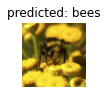

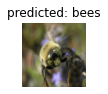

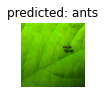

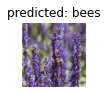

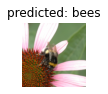

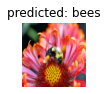

In [56]:
visualize_model(model)

### VGG 16

In [45]:
model = tv.models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Nikita/.cache\torch\hub\checkpoints\vgg16-397923af.pth


In [46]:
## Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [47]:
model.named_modules

<bound method Module.named_modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_s

In [48]:
model.classifier[6] = nn.Linear(4096, 2)

In [49]:
model.classifier = nn.Sequential(
        nn.Flatten(), nn.BatchNorm1d(25088),
        nn.Linear(25088, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 2))

In [50]:
model = model.to(device)

In [51]:
print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias
	 classifier.2.weight
	 classifier.2.bias
	 classifier.5.weight
	 classifier.5.bias
	 classifier.8.weight
	 classifier.8.bias


In [52]:
trainer = torch.optim.SGD(model.parameters(), lr=0.001)

In [55]:
train(model, train_iter, test_iter, trainer, 5)

Step. time since epoch: 6.544. Train acc: 0.500. Train Loss: 21.764
Step. time since epoch: 12.849. Train acc: 0.500. Train Loss: 21.343
Step. time since epoch: 19.139. Train acc: 0.688. Train Loss: 18.729
Step. time since epoch: 25.378. Train acc: 0.844. Train Loss: 18.402
Step. time since epoch: 31.745. Train acc: 0.625. Train Loss: 20.049
Step. time since epoch: 38.158. Train acc: 0.781. Train Loss: 18.279
Step. time since epoch: 44.954. Train acc: 0.688. Train Loss: 19.079
Step. time since epoch: 49.703. Train acc: 0.700. Train Loss: 11.308
epoch 1, loss 0.6105, train acc 0.664, test acc 0.889, time 77.9 sec
Step. time since epoch: 6.398. Train acc: 1.000. Train Loss: 10.741
Step. time since epoch: 12.624. Train acc: 1.000. Train Loss: 9.020
Step. time since epoch: 18.836. Train acc: 0.938. Train Loss: 9.626
Step. time since epoch: 25.249. Train acc: 0.969. Train Loss: 8.805
Step. time since epoch: 31.519. Train acc: 0.938. Train Loss: 7.304
Step. time since epoch: 37.923. Train ac

## Resnet 18 & VGG 16 with Fine Tuning & Data Augmentation

In [89]:
augs = tv.transforms.Compose([
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomVerticalFlip(),
    tv.transforms.Resize((224,224)),
    tv.transforms.ToTensor()    
    ])

train_dt_aug = tv.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=augs)
test_dt_aug = tv.datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=augs)

train_dt_aug_iter = torch.utils.data.DataLoader(train_dt_aug, batch_size=BATCH_SIZE, shuffle=True)
test_dt_aug_iter = torch.utils.data.DataLoader(test_dt_aug, batch_size=BATCH_SIZE,  shuffle=True)

In [90]:
model_aug = tv.models.resnet18(pretrained=True)

In [91]:
## Убираем требование градиента:
for param in model_aug.parameters():
    param.requires_grad = False

In [94]:
model_aug.fc

Linear(in_features=512, out_features=1000, bias=True)

In [95]:
model_aug.fc = nn.Linear(in_features=512, out_features=2)

In [96]:
model_aug = model_aug.to(device)

In [97]:
params_to_update = []
for name,param in model_aug.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

In [98]:
trainer = torch.optim.SGD(model_aug.parameters(), lr=0.0001, momentum=0.9)

In [101]:
train(model_aug, train_dt_aug_iter, test_dt_aug_iter, trainer, 5)

Step. time since epoch: 1.269. Train acc: 0.781. Train Loss: 15.017
Step. time since epoch: 2.516. Train acc: 0.750. Train Loss: 16.380
Step. time since epoch: 3.791. Train acc: 0.938. Train Loss: 11.251
Step. time since epoch: 5.254. Train acc: 0.781. Train Loss: 12.912
Step. time since epoch: 6.632. Train acc: 0.875. Train Loss: 9.262
Step. time since epoch: 7.945. Train acc: 0.906. Train Loss: 9.449
Step. time since epoch: 9.437. Train acc: 0.875. Train Loss: 10.927
Step. time since epoch: 10.272. Train acc: 0.900. Train Loss: 4.793
epoch 1, loss 0.3688, train acc 0.848, test acc 0.869, time 16.6 sec
Step. time since epoch: 1.222. Train acc: 0.969. Train Loss: 8.122
Step. time since epoch: 2.436. Train acc: 0.906. Train Loss: 9.169
Step. time since epoch: 3.676. Train acc: 0.938. Train Loss: 7.502
Step. time since epoch: 4.977. Train acc: 0.844. Train Loss: 12.129
Step. time since epoch: 6.253. Train acc: 0.875. Train Loss: 8.421
Step. time since epoch: 7.500. Train acc: 0.906. Trai